Imports, loading data and creating the graph

In [2]:
from collections import defaultdict
from itertools import combinations
from pathlib import Path
from gensim.models import Word2Vec
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [3]:
# Reads csv file into a pandas dataframe
articles = pd.read_csv(Path("data") / "articles.csv")

# Adds a new columns called node_id which corresponds to the index
articles["node_id"] = articles.index

# Make List into an array
articles["lists"] = articles["lists"].str.split("; ")

### REMOVE THIS BEFORE SUBMISSION HERE I AM TAKING A SAMPLE
#articles = articles.sample(n=10, random_state=42)
test_data = pd.read_csv(Path("data") / "test_data.csv")
train_data = pd.read_csv(Path("data") / "train_data.csv")

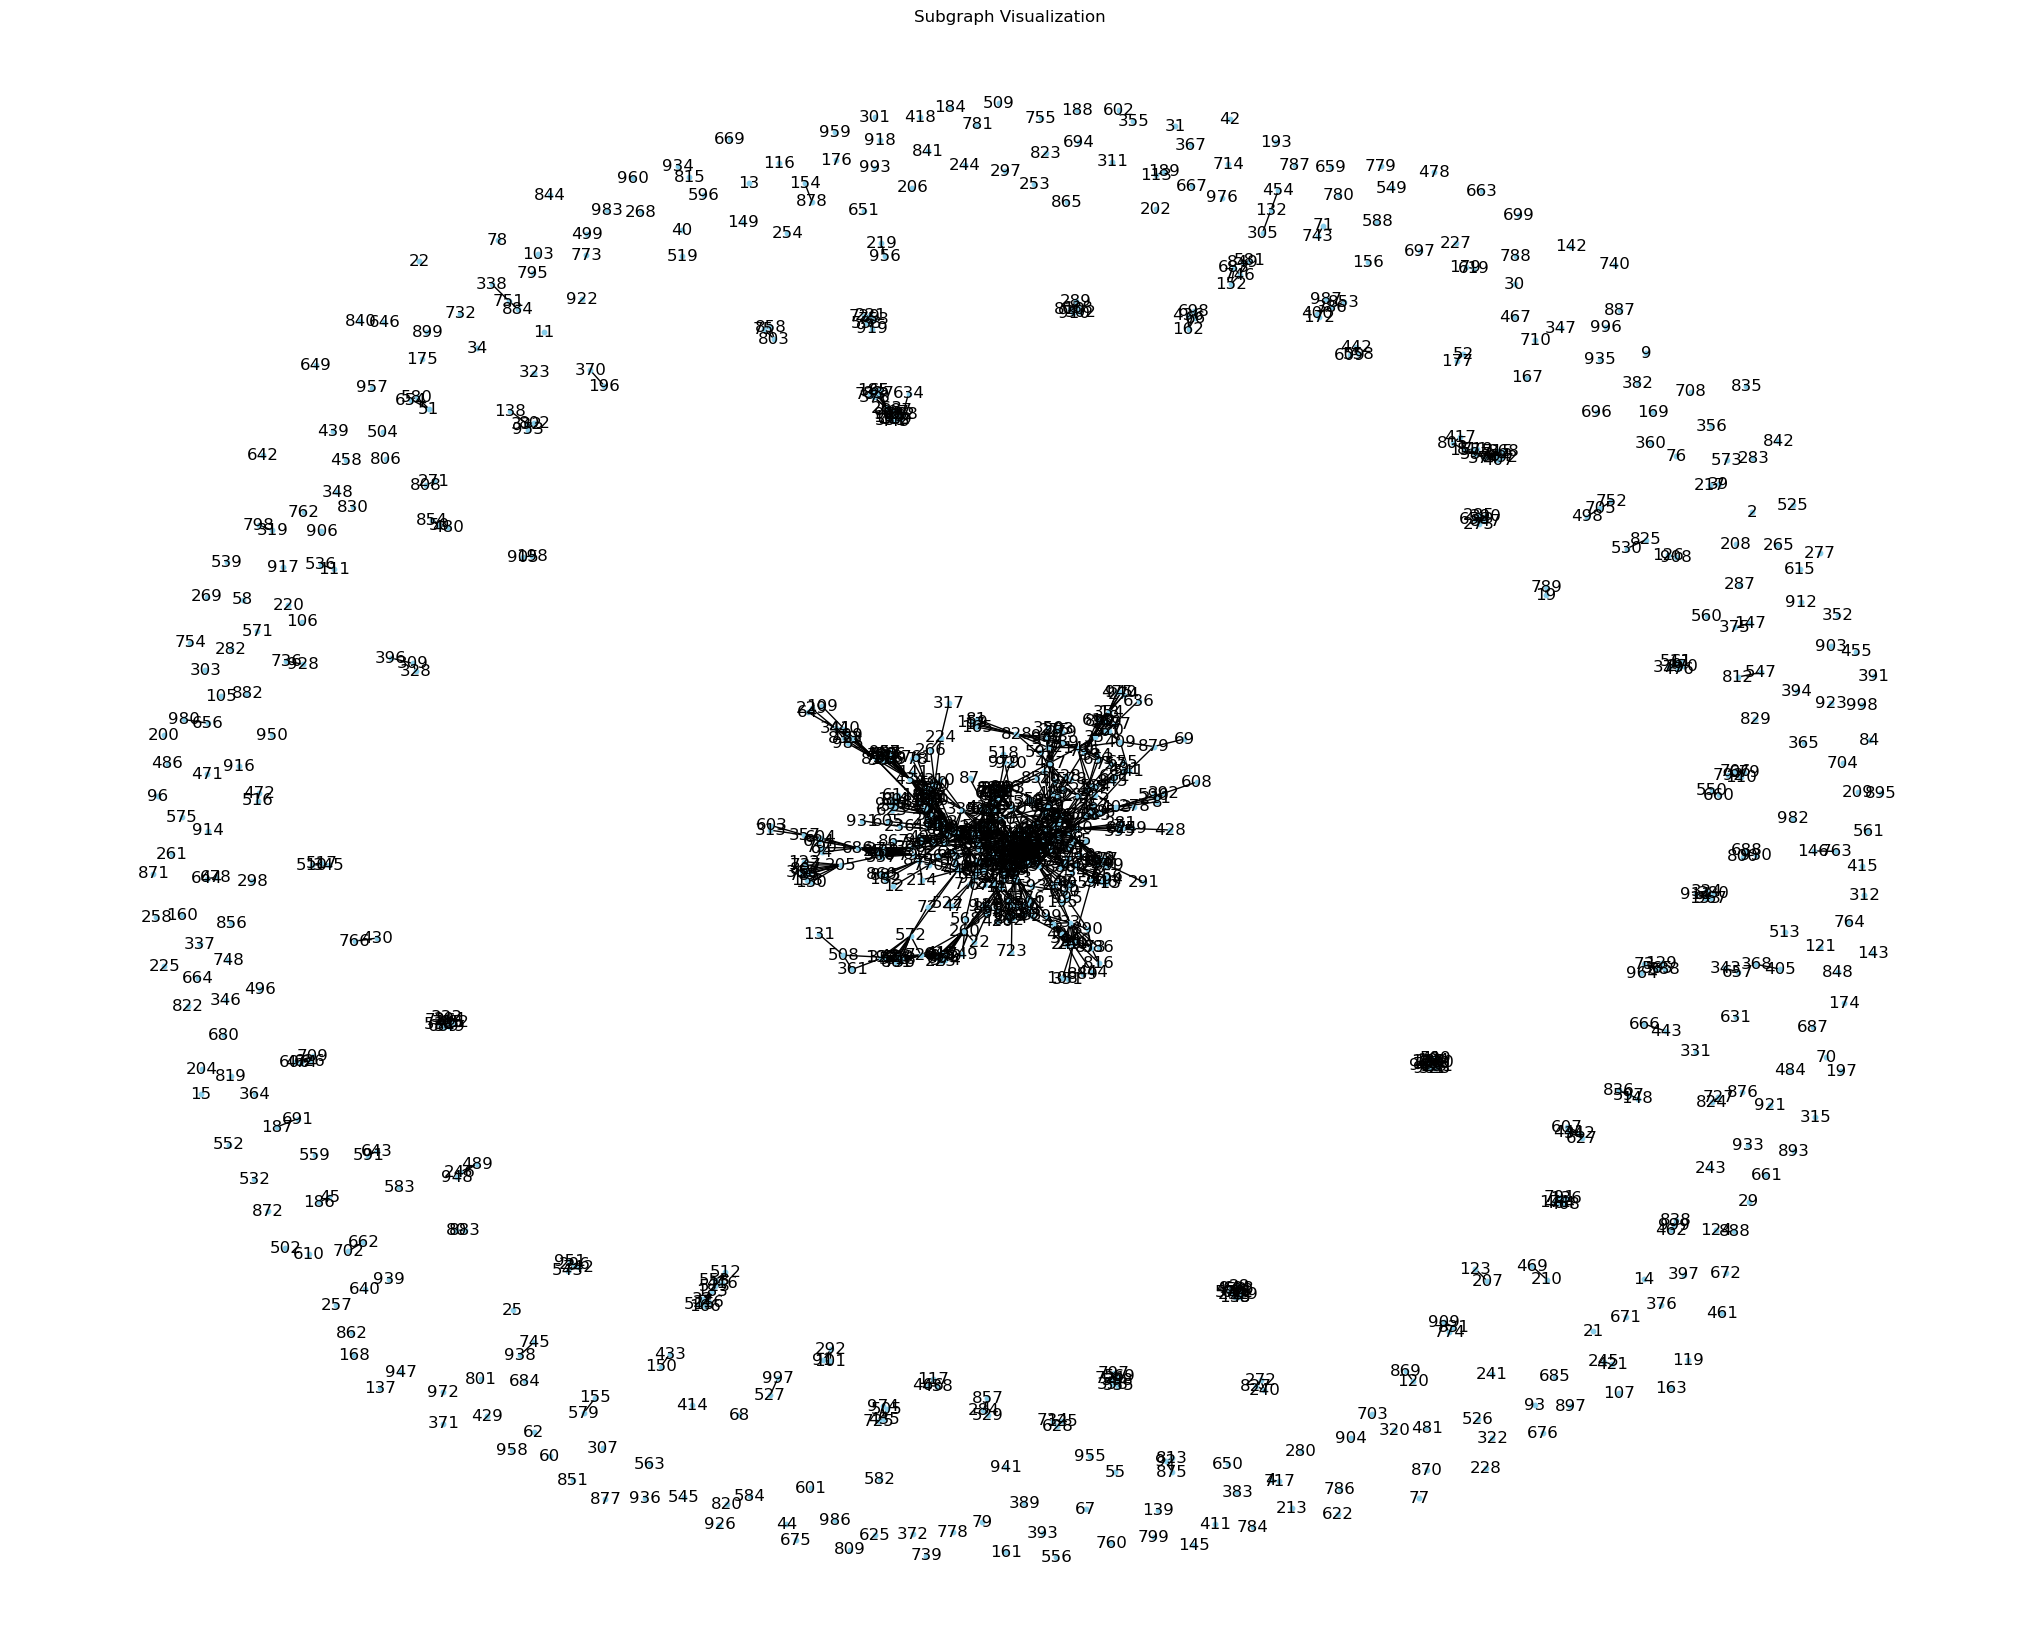

In [ ]:
medium_graph = nx.Graph()
medium_graph.add_nodes_from(articles["node_id"].to_list())

list_to_nodes = defaultdict(set)
for _, row in articles[["node_id", "lists"]].iterrows():
    for l in row["lists"]:
        list_to_nodes[l].add(row["node_id"])

for node_ids in list_to_nodes.values():
    medium_graph.add_edges_from(combinations(node_ids, 2))
    
## Drawing a subgraph for visualization, and will use during development
subgraph = medium_graph.subgraph(list(medium_graph.nodes)[:1000])

pyplot.figure(figsize=(20, 16))
nx.draw(subgraph, with_labels=True, node_size=10, node_color="skyblue")
pyplot.title("Subgraph Visualization")
pyplot.show()

## Familiarization

### Analysis of the Graph Statistics

## TODO: Talk about Sparse, non/Semantic and type of extraction.

In [5]:
number_nodes = medium_graph.number_of_nodes()
number_edges = medium_graph.number_of_edges()
list_of_node = medium_graph.nodes

nodes_neigbours = []
nodes_without_neighbours = []
for n in list_of_node:
    neigh = []
    for i in medium_graph.neighbors(n):
        neigh.append(i)
    if(len(neigh) == 0):
        nodes_without_neighbours.append(n)
    
    nodes_neigbours.append([n, len(neigh)])
    

print(f"Number of Nodes: {number_nodes}")
print(f"Number of Edges: {number_edges}")
print("")
print("Number of Neighbours of Each Node:")
print(nodes_neigbours)
print("")
print(f"Nodes without Neighbours: {len(nodes_without_neighbours)}")
print(nodes_without_neighbours)

Number of Nodes: 27718
Number of Edges: 2014162

Number of Neighbours of Each Node:
[[0, 144], [1, 102], [2, 18], [3, 34], [4, 15], [5, 8], [6, 317], [7, 154], [8, 198], [9, 37], [10, 129], [11, 1], [12, 34], [13, 14], [14, 1], [15, 7], [16, 56], [17, 56], [18, 145], [19, 55], [20, 50], [21, 19], [22, 33], [23, 21], [24, 228], [25, 8], [26, 858], [27, 827], [28, 320], [29, 2], [30, 30], [31, 13], [32, 92], [33, 271], [34, 1], [35, 66], [36, 865], [37, 602], [38, 1152], [39, 23], [40, 60], [41, 310], [42, 6], [43, 310], [44, 4], [45, 47], [46, 324], [47, 69], [48, 320], [49, 77], [50, 57], [51, 100], [52, 103], [53, 353], [54, 827], [55, 3], [56, 93], [57, 291], [58, 10], [59, 747], [60, 7], [61, 165], [62, 6], [63, 215], [64, 57], [65, 149], [66, 115], [67, 18], [68, 33], [69, 24], [70, 5], [71, 16], [72, 44], [73, 80], [74, 52], [75, 67], [76, 19], [77, 3], [78, 1], [79, 21], [80, 8], [81, 28], [82, 455], [83, 435], [84, 24], [85, 32], [86, 187], [87, 5], [88, 108], [89, 157], [90, 32

In [7]:
## Finding the unique Labels in Our Training Data

unique_labels = train_data["label"].unique()

# Print the unique labels
print("Unique Labels:")
for label in unique_labels:
    print(label)

Unique Labels:
software-development
artificial-intelligence
ux


## Spectral Node Embedding Computation

- Representin each node in a network into a low-dimension space, to provide insight into node similarity.

- By using the Laplacian we are breaking the Network based on its connectivity. When using the 2nd eigenvector method the Embedding Space is just R1, as it forms a bipartition, where a cluster belongs to one network or the other. How are neighbour less nodes impacted?

- Each node is a dimension, a dimention which is represented by a row in the adjacency matrix. 
- To extract similarities in the embedding space such as they will have in thier original network
- Encoders will encode the nodes from the graph network ot te embedding space.

In [23]:
def compute_spectral_embeddings(graph: nx.Graph, dim: int) -> np.ndarray:
    # We create the adjacency matrix using the graph, changed floatsize to 32 bit
    adjacency_matrix = nx.to_numpy_array(graph, nodelist=sorted(graph.nodes), dtype=np.float32)
    # assert (adjacency_matrix == adjacency_matrix.T).all()
    result = None
    
    ## This is the degree matrix, which is the degree of each vertex
    degree_matrix = np.diag(adjacency_matrix.sum(axis=1)) 
    
    ## Laplacian is the degree matrix with the negative of the adjacency matrix.
    laplacian_matrix = degree_matrix - adjacency_matrix

    ## Finding our 2nd eigenvector using np.linalg.eigh
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    print(eigenvalues[:15])
    result = eigenvectors[:,1]

    return result

# Using the alternative power Iteration method to find eigen vectors
def power_iteration(graph, n_vectors, e):
    matrix = nx.to_numpy_array(graph, nodelist=sorted(graph.nodes))
    assert (matrix.shape[0] == matrix.shape[1] & matrix.shape[1] >= n_vectors)
    eigen_vectors = list()
    for i in range(n_vectors):
        d = e + 1
        vk = np.ones(matrix.shape[0])
        vk_ = np.ones(matrix.shape[0])
        while d > e:
            vk = vk_
            vk_ = np.matmul(matrix, vk) / np.linalg.norm(np.matmul(matrix, vk))
            d = np.linalg.norm(vk_ - vk)
        eigen_vectors.append(vk_)
        matrix = matrix - np.outer(vk_, np.matmul(matrix, vk_)) * np.dot(vk_, vk_)
    return eigen_vectors

In [25]:
# spectral_eigvec = np.array(power_iteration(subgraph, 2,  10e-5)).T[:,1]
# print(spectral_eigvec.shape)
# cluster1 = []
# cluster2 = []

# for i in range(len(spectral_eigvec)):
#     if(spectral_eigvec[i] > 0):
#         cluster1.append(i)
#     else:
#         cluster2.append(i)
             
# print(cluster1)
# print(cluster2)

spectral_eigvec = compute_spectral_embeddings(subgraph, 2)
print(spectral_eigvec.shape)
x = [i for i in range(spectral_eigvec.shape[0])]
# Scatter plot the first and second dimensions of the spectral embedding
pyplot.figure(figsize=(20,16))
pyplot.scatter(x, spectral_eigvec, label="Dimension 2", s=10)  # Plot 2nd dimension on y-axis
pyplot.legend()

pyplot.show()
# cluster1 = []
# cluster2 = []

# for i in range(len(spectral_eigvec)):
#     if(spectral_eigvec[i] > 0):
#         cluster1.append(i)
#     else:
#         cluster2.append(i)
             
# print(cluster1)
# print(cluster2)

SyntaxError: invalid syntax (2578940394.py, line 20)

## Word2Vec Computing Embeddings


Steps:
1. Define an econder here we will use Node2Vec
    Here we can use : DeepWalk, node2vec, TransE
2. Define a node similarity function
    Random Walk : similarity between node u and v is defined as the probability that u and v co-occur on a random walk over a network
3. Optimize the parameters of the encoder so that similarity of u anv v in the network approximate the do product between node embedding: simularity(u,v) ~ ZuT*Zv

In [22]:
# Performing Random Walk
def random_walks(graph: nx.Graph, num_walks: int, walk_length: int) -> np.ndarray:
    result = []

    for node in graph.nodes():
        for i in range(num_walks):
            walk = [node]
            for j in range(walk_length - 1):
                current_node = walk[-1]
                neighbors_list = list(graph.neighbors(current_node))
                
                if len(neighbors_list) == 0:
                    break  # Stop walk if there are no neighbors (isolated node)
                
                # Randomly choose a neighbor
                index = np.random.randint(len(neighbors_list))
                next_node = neighbors_list[index]
                walk.append(next_node)
                
             # Pad shorter walks with None as we want to create equal length np arrays   
            if len(walk) < walk_length:
                walk.extend([None] * (walk_length - len(walk)))
            result.append(walk)

    return result


In [29]:
walks = random_walks(graph = medium_graph, num_walks= 5, walk_length = 50)

- In the Word2Vec each walk is treated like a sentence
- 

In [30]:
# walks = [list(filter(lambda x: x is not None, walk)) for walk in randomWalks] ## Removing the None values

## Each Walk is treated like a sentence
model = Word2Vec(sentences=[list(map(str, walk)) for walk in walks], vector_size=128, window=5, min_count=1, sg=0)

node_id = 0
vector = model.wv[node_id]
print(f"Vector for node {node_id}: {vector}")


Vector for node 0: [ 7.1656662e-01 -4.3972057e-01  2.4706810e+00  1.5473670e+00
 -2.1816995e+00 -2.1316390e+00  1.2858202e+00  1.2434959e+00
 -9.0390652e-01 -8.3190602e-01  2.0941253e+00  1.9087226e+00
 -1.2577527e+00  2.3290126e+00  1.0756060e-02 -2.2636394e-01
  8.4665433e-02  4.5697573e-01 -9.1887695e-01 -2.5492873e+00
  4.8237196e-01  4.6645865e-01  2.4543676e+00 -1.0619969e+00
  1.2783186e+00 -1.7462275e+00 -2.7132660e-01  1.3726221e+00
 -8.3155710e-01 -1.9206471e+00 -2.1616530e+00 -2.3224516e-01
  2.9732974e+00  8.3462507e-01  1.4477795e-02 -3.8448060e-01
  2.4109821e+00  2.6133662e-02  1.2941598e+00 -6.5288556e-01
 -1.0853148e+00  4.3842234e-02 -1.1725897e+00 -3.3642563e-01
  7.5589609e-01  1.2170711e+00 -3.0420809e+00  2.6689370e+00
  1.0366213e+00  1.4257796e+00 -2.3299620e+00  8.1886524e-01
 -2.0142309e-01  8.3328974e-01  1.9857683e+00  3.0775841e-02
  9.3536741e-01  3.9732162e-02  5.2666032e-01  2.0983787e+00
 -1.5554347e+00 -1.4961517e+00 -3.4700420e-01 -6.6141278e-01
 -2.5